In [45]:
import gzip
import random
from collections import defaultdict
import numpy as np
import json
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
import itertools
import matplotlib.pyplot as plt

In [2]:
def parseData(fname):
    for l in open(fname):
        if l is "null": continue
        yield json.loads(l)

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-4200bd411368>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if l is "null": continue


In [3]:
print("Reading data...")
data = list(parseData("modcloth_final_data.json"))
print("done")

Reading data...
done


In [4]:
data[0]

{'item_id': '123373',
 'waist': '29',
 'size': 7,
 'quality': 5,
 'cup size': 'd',
 'hips': '38',
 'bra size': '34',
 'category': 'new',
 'bust': '36',
 'height': '5ft 6in',
 'user_name': 'Emily',
 'length': 'just right',
 'fit': 'small',
 'user_id': '991571'}

In [5]:
len(data)

82790

In [6]:
np.unique([d[' review_text'] for d in data if " review_text" in d])

array([], dtype=float64)

In [7]:
len([d['review_summary'] for d in data if "review_summary" in d])

76065

In [8]:
len([d for d in data if "cup size" in d])

76535

In [9]:
len([d for d in data if "bra size" in d])

76772

In [10]:
len([d for d in data if "height" in d])

81683

In [11]:
modData = [d for d in data if "bra size" in d and "cup size" in d 
           and "height" in d and (d['category']!='bottoms') and (d['size'] < 22)]
len(modData)

54130

In [12]:
np.unique([d['cup size'] for d in modData])

array(['a', 'aa', 'b', 'c', 'd', 'dd/e', 'ddd/f', 'dddd/g', 'h', 'i', 'j',
       'k'], dtype='<U6')

In [13]:
len(np.unique([d['cup size'] for d in modData]))

12

In [14]:
len(np.unique([d['bra size'] for d in modData]))

11

In [15]:
#np.unique([d['hips'] for d in modData])

In [16]:
np.unique([d['height'] for d in modData])

array(['3ft', '3ft 11in', '3ft 3in', '3ft 4in', '3ft 6in', '4ft 10in',
       '4ft 11in', '4ft 2in', '4ft 4in', '4ft 7in', '4ft 8in', '4ft 9in',
       '5ft', '5ft 10in', '5ft 11in', '5ft 1in', '5ft 2in', '5ft 3in',
       '5ft 4in', '5ft 5in', '5ft 6in', '5ft 7in', '5ft 8in', '5ft 9in',
       '6ft', '6ft 1in', '6ft 2in', '6ft 3in', '6ft 4in', '6ft 5in',
       '6ft 6in', '6ft 8in', '7ft 11in', '7ft 3in', '7ft 5in'],
      dtype='<U8')

In [17]:
for d in modData:
    h = d['height']
    s = h.strip().split()
    ft = (int)(s[0].split('ft')[0])
    try:
        inches = (int)(s[1].split('in')[0])
    except:
        inches = 0
    finally:
        height = (ft*12) + inches 
        d['modHeight'] = height

In [18]:
# for d in modData:
#     d['hips'] = int((float)(d['hips']))
# modData[0]

In [19]:
catCups = np.unique([d['cup size'] for d in modData])
catCups[0] = 'aa'
catCups[1] = 'a'
catCupsID = dict(zip(list(catCups),range(len(catCups))))
print(catCupsID)

{'aa': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'dd/e': 5, 'ddd/f': 6, 'dddd/g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11}


In [20]:
catBra = np.unique([d['bra size'] for d in modData])
catBraID = dict(zip(list(catBra),range(len(catBra))))

In [21]:
def featCups(d):
    feat = []
    feat = [0] * len(catCupsID)
    feat[catCupsID[d['cup size']]] = 1
    return [catCupsID[d['cup size']]]

In [22]:
def featBra(d):
    feat = []
    feat = [0] * len(catBraID)
    feat[catBraID[d['bra size']]] = 1
    return feat

In [23]:
for d in modData:
    size = d['size']
    if size <= 2:
        d['catSize'] = 0
    elif size <= 6:
        d['catSize'] =1
    elif size <= 10:
        d['catSize']=2
    elif size <= 14:
        d['catSize'] = 3
    elif size <= 18:
        d['catSize'] = 4
    else:
        d['catSize'] =5

In [24]:
def printAcc(model,vadArr, testArr):
    # In validation set
    # Predict one size
    T=0
    ypredValid = model.predict(Xvalid)
    T = sum([(a == b) for (a,b) in zip(yvalid, ypredValid)])
    vadArr.append(T/len(yvalid)*100)
    print("In validation set, accuracy when predict one size is:",format(T/len(yvalid)*100, '.2f'), "%", sep="")
    # Predict two size
    yprob = model.predict_proba(Xvalid)
    yprob_ = []
    for y in yprob:
        sorted_dict = {}
        data = dict(zip(range(len(y)),list(y.round(2))))
        sorted_y = sorted(data, key=data.get, reverse=True)
        for w in sorted_y:
            sorted_dict[w] = data[w]
        yprob_.append(dict(itertools.islice(sorted_dict.items(), 2)))
    y2size = [[list(d.keys())[0], list(d.keys())[1]] for d in yprob_]
    T_ = 0
    T_ = sum([(a == b[0] or a == b[1]) for (a,b) in zip(yvalid, y2size)])
    vadArr.append(T_/len(yvalid)*100)
    print("In validation set, accuracy when predict two size is:", format(T_/len(yvalid)*100, '.2f'), "%", sep="")
    
    # In test set
    # Predict one size
    T=0
    ypredTest = model.predict(Xtest)
    T = sum([(a == b) for (a,b) in zip(ytest, ypredTest)])
    testArr.append(T/len(yvalid)*100)
    print("In test set, accuracy when predict one size is:",format(T/len(yvalid)*100, '.2f'), "%", sep="")
    # Predict two size
    yprob = model.predict_proba(Xtest)
    yprob_ = []
    for y in yprob:
        sorted_dict = {}
        data = dict(zip(range(len(y)),list(y.round(2))))
        sorted_y = sorted(data, key=data.get, reverse=True)
        for w in sorted_y:
            sorted_dict[w] = data[w]
        yprob_.append(dict(itertools.islice(sorted_dict.items(), 2)))
    y2size = [[list(d.keys())[0], list(d.keys())[1]] for d in yprob_]
    T_ = 0
    T_ = sum([(a == b[0] or a == b[1]) for (a,b) in zip(ytest, y2size)])
    testArr.append(T_/len(ytest)*100)
    print("In test set, accuracy when predict two size is:", format(T_/len(ytest)*100, '.2f'), "%", sep="")
    

### Baseline model

In [25]:
X = [[1] + [(int)(d['bra size'])]  for d in modData] 
y = [d['catSize'] for d in modData]

In [26]:
N = len(X)
Xtrain = X[:N//2]
Xvalid = X[N//2:3*N//4]
Xtest = X[3*N//4:]
ytrain = y[:N//2]
yvalid = y[N//2:3*N//4]
ytest = y[3*N//4:]

In [27]:
modelLR = linear_model.LogisticRegression(C=10**4, max_iter=10**4, fit_intercept = False)
modelLR.fit(Xtrain,ytrain)

LogisticRegression(C=10000, fit_intercept=False, max_iter=10000)

In [28]:
basedline_vad = []
basedline_test = []

In [29]:
printAcc(modelLR,basedline_vad,basedline_test)

In validation set, accuracy when predict one size is:45.29%
In validation set, accuracy when predict two size is:75.01%
In test set, accuracy when predict one size is:46.21%
In test set, accuracy when predict two size is:73.65%


### Our model

In [30]:
X = [[1] + featCups(d) + [(int)(d['bra size'])] + [d['modHeight']]  for d in modData] 
y = [d['catSize'] for d in modData]

In [31]:
N = len(X)
Xtrain = X[:N//2]
Xvalid = X[N//2:3*N//4]
Xtest = X[3*N//4:]
ytrain = y[:N//2]
yvalid = y[N//2:3*N//4]
ytest = y[3*N//4:]

### Naive Bayes

In [32]:
modelNB = GaussianNB()
modelNB.fit(Xtrain,ytrain)

GaussianNB()

In [33]:
naiveBayes_vad = []
naiveBayes_test = []

In [34]:
printAcc(modelNB,naiveBayes_vad,naiveBayes_test)

In validation set, accuracy when predict one size is:50.33%
In validation set, accuracy when predict two size is:79.35%
In test set, accuracy when predict one size is:51.38%
In test set, accuracy when predict two size is:78.53%


### Logistic Regression

In [35]:
modelLR = linear_model.LogisticRegression(C=10**4, max_iter=10**4, fit_intercept = False)
modelLR.fit(Xtrain,ytrain)

LogisticRegression(C=10000, fit_intercept=False, max_iter=10000)

In [36]:
LogReg_vad = []
LogReg_test = []

In [37]:
printAcc(modelLR,LogReg_vad,LogReg_test)

In validation set, accuracy when predict one size is:51.06%
In validation set, accuracy when predict two size is:79.83%
In test set, accuracy when predict one size is:52.10%
In test set, accuracy when predict two size is:79.17%


In [38]:
# sum([d <= 1 for d in abs(ytest - ypredTest)])/len(ytest)

### SVM

In [39]:
svclassifier = SVC(kernel='linear', probability=True)
# svclassifier = SVC(kernel='linear')
svclassifier.fit(Xtrain, ytrain)

SVC(kernel='linear', probability=True)

In [40]:
# T=0
# ypredValid = svclassifier.predict(Xvalid)
# T = sum([(a == b) for (a,b) in zip(yvalid, ypredValid)])
# print("In validation set, accuracy when predict one size is:",format(T/len(yvalid)*100, '.2f'), "%", sep="")

In [41]:
SVM_vad = []
SVM_test = []

In [42]:
printAcc(svclassifier,SVM_vad,SVM_test)

In validation set, accuracy when predict one size is:51.15%
In validation set, accuracy when predict two size is:79.86%
In test set, accuracy when predict one size is:52.17%
In test set, accuracy when predict two size is:79.12%


In [43]:
# print(confusion_matrix(yvalid,ypredValid2))
# print(classification_report(yvalid,ypredValid2))

In [44]:
# sum([d <= 1 for d in abs(yvalid - ypredValid2)])/len(yvalid)

[Text(0, 0, 'vadSet'), Text(0, 0, 'testSet')]

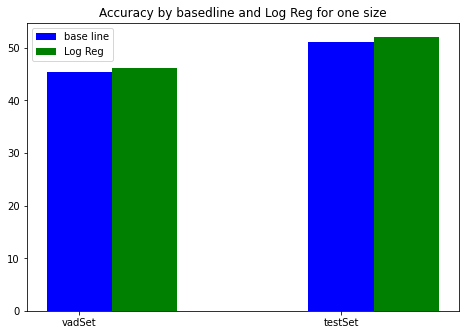

In [85]:
labels = ['vadSet','testSet']
x = np.arange(len(labels))
data = [[basedline_vad[0],LogReg_vad[0]],
[basedline_test[0],LogReg_test[0]]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X +0.0 , data[0], color = 'b', width = 0.25)
ax.bar(X +0.25, data[1], color = 'g', width = 0.25)
ax.set_title('Accuracy by basedline and Log Reg for one size')
ax.legend(labels=['base line', 'Log Reg'])
ax.set_xticks(x)
ax.set_xticklabels(labels)

[Text(0, 0, 'vadSet'), Text(0, 0, 'testSet')]

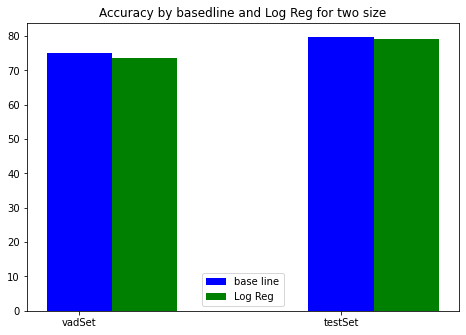

In [86]:
labels = ['vadSet','testSet']
x = np.arange(len(labels))
data = [[basedline_vad[1],LogReg_vad[1]],
[basedline_test[1],LogReg_test[1]]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X +0.0 , data[0], color = 'b', width = 0.25)
ax.bar(X +0.25, data[1], color = 'g', width = 0.25)
ax.set_title('Accuracy by basedline and Log Reg for two size')
ax.legend(labels=['base line', 'Log Reg'])
ax.set_xticks(x)
ax.set_xticklabels(labels)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

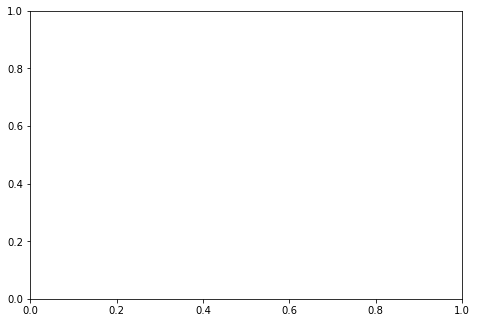

In [96]:
labels = ['vadSet','testSet']
x = np.arange(len(labels))
data = [[naiveBayes_vad[0],LogReg_vad[0],SVM_vad[0]],
[naiveBayes_test[0],LogReg_test[0],SVM_test[0]]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X +0.0 , data[0], color = 'b', width = 0.25)
ax.bar(X +0.25, data[1], color = 'g', width = 0.25)
ax.bar(X +0.5, data[1], color = 'r', width = 0.25)
ax.set_title('Accuracy by NaiveBayes, Log Reg, and SVM for one size')
ax.legend(labels=['Naive Bayes', 'Log Reg','SVM'])
ax.set_xticks(x)
ax.set_xticklabels(labels)

[[30, 25, 50, 20], [40, 23, 51, 17], [35, 22, 45, 19]]